# Configuring Nuclio
---

In [38]:
# nuclio: ignore
import nuclio

In [39]:
%nuclio config kind="serving"

# tensorflow 2 use the default serving image (or the mlrun/ml-models for a faster build)

%nuclio config spec.build.baseImage = "mlrun/mlrun"

%nuclio: setting kind to 'serving'
%nuclio: setting spec.build.baseImage to 'mlrun/mlrun'


In [40]:
%%nuclio cmd -c
pip install tensorflow>=2.4.1
pip install requests pillow

In [46]:
SERVING_MODEL_POSENET = os.path.join(os.getcwd(), "YogaNet_Model_3_MobileNet.h5")

'/User/prac_deployment/YogaNet_Model_3_MobileNet.h5'

# Installing Project Dependencies
---

In [35]:
!pip install h5py

In [42]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [43]:
import json
import numpy as np
import requests
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from os import environ, path
from PIL import Image
from io import BytesIO
from urllib.request import urlopen
import mlrun
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import os

# Model Functions
---

In [44]:
class TFModel(mlrun.serving.V2ModelServer):

    def load(self):
        self.IMAGE_WIDTH = int(environ.get('IMAGE_WIDTH', '224'))
        self.IMAGE_HEIGHT = int(environ.get('IMAGE_HEIGHT', '224'))
        
        try:
            with open(environ['classes_map'], 'r') as f:
                self.classes = json.load(f)
        except:
            self.classes = None
        
        model_file, extra_data = self.get_model('.h5')
        self.model = load_model(model_file)
        
    def preprocess(self, body, operation):
        try:
            output = {'inputs': []}
            inputs = body.get('inputs', [])
            for byte_image in inputs:
                img = Image.open(byte_image)
                img = img.resize((self.IMAGE_WIDTH, self.IMAGE_HEIGHT))

                # Load image
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                output['inputs'].append(x)
            
            # Format inputs list
            output['inputs'] = [np.vstack(output['inputs'])]
            return output
        except:
            raise Exception(f'received: {body}')
            

    def predict(self, data):
        images = data.get('inputs', [])

        # Predict
        predicted_probability = self.model.predict(images)

        # return prediction
        return predicted_probability.tolist()[0]

In [48]:
import os
from mlrun import mlconf
from mlrun import code_to_function, mount_v3io

model_class = 'TFModel'
model_name = 'PoseNet' # Define for later use in tests
models = {model_name: os.path.join(os.getcwd(), 'YogaNet_Model_3_MobileNet.h5')}

function_envs = {
     'IMAGE_HEIGHT': 224,
     'IMAGE_WIDTH': 224,
}

## Setup the Model Server Function

In [50]:
fn = code_to_function('tf2-serving-v2', kind="serving")
fn.spec.description = "tf2 image classification server v2"
fn.metadata.categories = ['serving', 'dl']
fn.metadata.labels = {'author': 'aayush'}
fn.export("function.yaml")
fn.set_envs(function_envs)
fn.add_model(key="model",
             model_path= SERVING_MODEL_POSENET,
             class_name="TFModel")

> 2021-07-03 10:56:20,122 [info] function spec saved to path: function.yaml


In [51]:
fn.apply(mount_v3io())

## Serving the Model

In [52]:
addr = fn.deploy(project='stay-fit')

> 2021-07-03 10:56:33,915 [info] Starting remote function deploy
2021-07-03 10:56:34  (info) Deploying function
2021-07-03 10:56:34  (info) Building
2021-07-03 10:56:34  (info) Staging files and preparing base images
2021-07-03 10:56:34  (info) Building processor image
2021-07-03 10:56:36  (info) Build complete
2021-07-03 10:56:48  (info) Function deploy complete
> 2021-07-03 10:56:48,605 [info] function deployed, address=default-tenant.app.mlops6.iguazio-c0.com:32700


# Testing the Model

Test image:


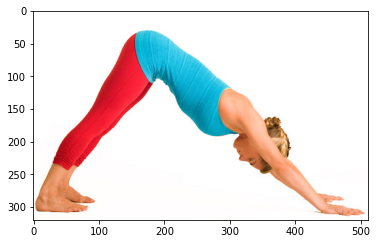

In [56]:
yoga_image_url = 'https://lh3.googleusercontent.com/proxy/4Wb2wKotRZ7bDmQoKNnftKcmmFlojnblPB6kqcy0QgC97MwdgiQXVwI77UJ6LGcZkvuLpeZHED3av2nRVwelKw2sBMMmD3Ku7On2fNXamLbTUQ'
response = requests.get(yoga_image_url)
yoga_image = response.content
img = Image.open(BytesIO(yoga_image))

print('Test image:')
plt.imshow(img)

In [57]:
payload = json.dumps({"data_url" : yoga_image_url})
fn.invoke(path='/v2/models/model/predict', body=payload)
fn.invoke(path='/v2/models/model/predict',
          body=yoga_image,
          headers={'Content-type': 'image/jpeg'})

{'id': 'e90baa16-e73a-430a-bea3-dc3c8d263ffc',
 'model_name': 'model',
 'outputs': [0.9999656677246094,
  1.2034264500471181e-06,
  8.157017873600125e-06,
  1.604775206942577e-05,
  8.992552466224879e-06]}

In [53]:
addr

'http://default-tenant.app.mlops6.iguazio-c0.com:32700'